# Tutorial 2
We show how to train DeepScalper on BTC trading.

## Step 1: Import Packages
Modify the system path and load the corresponding packages and functions 

In [1]:
import os
import sys

import warnings
warnings.filterwarnings("ignore")

ROOT = os.path.dirname(os.path.abspath("."))
sys.path.append(ROOT)

import torch
import argparse
import os.path as osp
from mmcv import Config
from trademaster.utils import replace_cfg_vals
from trademaster.nets.builder import build_net
from trademaster.environments.builder import build_environment
from trademaster.datasets.builder import build_dataset
from trademaster.agents.builder import build_agent
from trademaster.optimizers.builder import build_optimizer
from trademaster.losses.builder import build_loss
from trademaster.trainers.builder import build_trainer
from trademaster.transition.builder import build_transition
from trademaster.utils import plot
from trademaster.utils import set_seed
set_seed(2023)

2023-03-04 18:50:27,916	INFO services.py:1476 -- View the Ray dashboard at http://127.0.0.1:8266
2023-03-04 18:50:30,042	INFO worker.py:973 -- Calling ray.init() again after it has already been called.


## Step 2: Load Configs
Load default config from the file `configs/algorithmic_trading/algorithmic_trading_BTC_deepscalper_deepscalper_adam_mse.py`

In [2]:

parser = argparse.ArgumentParser(description='Download Alpaca Datasets')
parser.add_argument("--config", default=osp.join(ROOT, "configs", "algorithmic_trading", "algorithmic_trading_BTC_deepscalper_deepscalper_adam_mse.py"),
                    help="download datasets config file path")
parser.add_argument("--task_name", type=str, default="train")
args, _= parser.parse_known_args()

cfg = Config.fromfile(args.config)
task_name = args.task_name
cfg = replace_cfg_vals(cfg)

In [3]:
cfg

Config (path: /data/sunshuo/qml/TradeMaster/configs/algorithmic_trading/algorithmic_trading_BTC_deepscalper_deepscalper_adam_mse.py): {'data': {'type': 'AlgorithmicTradingDataset', 'data_path': 'data/algorithmic_trading/BTC', 'train_path': 'data/algorithmic_trading/BTC/train.csv', 'valid_path': 'data/algorithmic_trading/BTC/valid.csv', 'test_path': 'data/algorithmic_trading/BTC/test.csv', 'test_dynamic_path': 'data/algorithmic_trading/BTC/test_labeled_3_24_-0.15_0.15.csv', 'tech_indicator_list': ['high', 'low', 'open', 'close', 'adjcp', 'zopen', 'zhigh', 'zlow', 'zadjcp', 'zclose', 'zd_5', 'zd_10', 'zd_15', 'zd_20', 'zd_25', 'zd_30'], 'backward_num_day': 5, 'forward_num_day': 5, 'test_dynamic': '-1'}, 'environment': {'type': 'AlgorithmicTradingEnvironment'}, 'agent': {'type': 'AlgorithmicTradingDQN', 'max_step': 12345, 'reward_scale': 1, 'repeat_times': 1, 'gamma': 0.9, 'batch_size': 64, 'clip_grad_norm': 3.0, 'soft_update_tau': 0, 'state_value_tau': 0.005}, 'trainer': {'type': 'Algori

## Step 3: Build Dataset

In [4]:
dataset = build_dataset(cfg)

## Step 4: Build Reinforcement Learning Environments
Build environments based on cfg and predefined dataset

In [5]:
train_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="train"))
valid_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="valid"))
test_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="test"))

In [6]:
train_environment.df.head()

,tic,date,high,low,open,close,adjcp,zopen,zhigh,zlow,zadjcp,zclose,zd_5,zd_10,zd_15,zd_20,zd_25,zd_30
0,BTC,2016-01-24 23:59:59,405.484985,387.510010,388.101990,402.971008,402.971008,-0.036898,0.006239,-0.038368,0.0,0.039949,-0.005662,-0.030965,0.009124,0.032291,0.040384,0.042514
1,BTC,2016-01-25 23:59:59,402.316986,388.553986,402.316986,391.726013,391.726013,0.027037,0.027037,-0.008098,0.0,-0.027905,0.008328,0.003846,0.028517,0.056789,0.066283,0.070267
2,BTC,2016-01-26 23:59:59,397.765991,390.575012,392.002014,392.153015,392.153015,-0.000385,0.014313,-0.004024,0.0,0.001090,-0.002005,0.003930,0.017830,0.050927,0.060819,0.066495
3,BTC,2016-01-27 23:59:59,396.842987,391.782013,392.444000,394.971985,394.971985,-0.006400,0.004737,-0.008076,0.0,0.007188,-0.002809,-0.000027,0.003693,0.035441,0.049353,0.056578
4,BTC,2016-01-28 23:59:59,395.502014,379.734985,395.145996,380.289001,380.289001,0.039068,0.040004,-0.001457,0.0,-0.037175,0.031905,0.036773,0.033315,0.065830,0.084638,0.092754


## Step 5: Build Net 
Update information about the state and action dimension. Create networks and optimizer for DeepScalper


In [7]:
action_dim = train_environment.action_dim
state_dim = train_environment.state_dim

cfg.act.update(dict(action_dim=action_dim, state_dim=state_dim))
act = build_net(cfg.act)
act_optimizer = build_optimizer(cfg, default_args=dict(params=act.parameters()))
if cfg.cri:
    cfg.cri.update(dict(action_dim=action_dim, state_dim=state_dim))
    cri = build_net(cfg.cri)
    cri_optimizer = build_optimizer(cfg, default_args=dict(params=cri.parameters()))
else:
    cri = None
    cri_optimizer = None

## Step 6: Build Loss

In [8]:
criterion = build_loss(cfg)

## Step 7: Build Transition

In [9]:
transition = build_transition(cfg)


## Step 8: Build Agent

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent = build_agent(cfg, default_args=dict(action_dim = action_dim,state_dim = state_dim,act = act,cri = cri,act_optimizer = act_optimizer,cri_optimizer = cri_optimizer, criterion = criterion,transition = transition,device=device))

## Step 9: Build Trainer
Build trainer from config and create work directionary to save the result, model and config

In [11]:
trainer = build_trainer(cfg, default_args=dict(train_environment=train_environment,valid_environment=valid_environment,test_environment=test_environment,agent=agent,device=device))

| Arguments Keep work_dir: /data/sunshuo/qml/TradeMaster/work_dir/algorithmic_trading_BTC_deepscalper_deepscalper_adam_mse


## Step 10: Train the RL Agent
Train the trainer based on the config and save results in workdir

In [12]:
trainer.train_and_valid()

Train Episode: [1/2]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
| 663.053338%  |   1.465309  | 3.726925%  |  63.966805%  |
+--------------+-------------+------------+--------------+
Valid Episode: [1/2]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
| -35.444878%  |   0.430537  | 42.560375% | 118.689588%  |
+--------------+-------------+------------+--------------+
Train Episode: [2/2]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
| 967.324329%  |   1.621369  | 3.868479%  |  64.052556%  |
+--------------+-------------+------------+--------------+
Valid Episode: [2/2]
+--------------+-------------+-

## Step 11: RL Agent Testing

In [13]:
trainer.test();

Resume checkpoint /data/sunshuo/qml/TradeMaster/work_dir/algorithmic_trading_BTC_deepscalper_deepscalper_adam_mse/checkpoints/best.pth
Test Best Episode
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
| 218.177594%  |   1.966325  | 2.131242%  |  29.503340%  |
+--------------+-------------+------------+--------------+


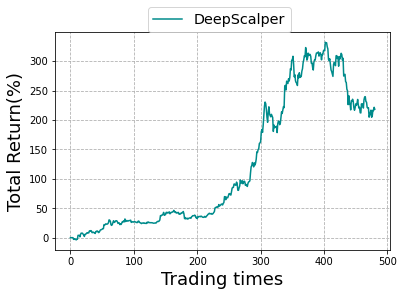

In [14]:
plot(trainer.test_environment.save_asset_memory(),alg="DeepScalper")